## Supply Chain Optimisation

### Predicting delivery risk
what is the probability that the shipment would arrive late?

### Dataset

The PEPFAR Supply Chain Management System (SCMS) Delivery History dataset contains detailed, shipment-level records for antiretroviral (ARV) and HIV laboratory testing kits delivered to various countries. This data is primarily used for analyzing logistics performance, such as on-time delivery percentages, delivery delays, and costs.

In [ ]:
import os
os.chdir("/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
file_path = "data/supply_chain.csv"
try:
  df = pd.read_csv(file_path,encoding='latin1')
except Exception as e:
  print(e)

### Data Analysis

In [ ]:
#create a copy of the original dataframe for EDA
eda_df = df.copy()
eda_df.shape

(10324, 33)

In [90]:
eda_df.head(5)

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),delay_days,late
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN,0,0
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN,0,0
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN,0,0
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN,0,0
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN,0,0


In [57]:
# check the info of the dataframe
eda_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  str    
 2   PQ #                          10324 non-null  str    
 3   PO / SO #                     10324 non-null  str    
 4   ASN/DN #                      10324 non-null  str    
 5   Country                       10324 non-null  str    
 6   Managed By                    10324 non-null  str    
 7   Fulfill Via                   10324 non-null  str    
 8   Vendor INCO Term              10324 non-null  str    
 9   Shipment Mode                 9964 non-null   str    
 10  PQ First Sent to Client Date  10324 non-null  str    
 11  PO Sent to Vendor Date        10324 non-null  str    
 12  Scheduled Delivery Date       10324 non-null  str    
 13  Delivered to

In [65]:
# identify the categorical, numerical and date columns
cat_cols = eda_df.select_dtypes(include=['str','object']).columns.to_list()
num_cols = eda_df.select_dtypes(include=['int64','float64']).columns.to_list()
date_cols = [curr_col for curr_col in cat_cols if 'date' in curr_col.lower()]

#convert str to datetime
for col in date_cols:
    eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')

print(num_cols)
print(cat_cols)
print(date_cols)

['ID', 'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value', 'Pack Price', 'Unit Price', 'Line Item Insurance (USD)']
['Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country', 'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode', 'PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date', 'Product Group', 'Sub Classification', 'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form', 'Manufacturing Site', 'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)']
['PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']


/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_16457/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_16457/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_16457/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlb

In [66]:
#null values in the dataframe
eda_df.isnull().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date    2681
PO Sent to Vendor Date          5732
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

In [67]:
#duplicate values in the dataframe
eda_df.duplicated().sum()

np.int64(0)

late
0    0.885122
1    0.114878
Name: proportion, dtype: float64

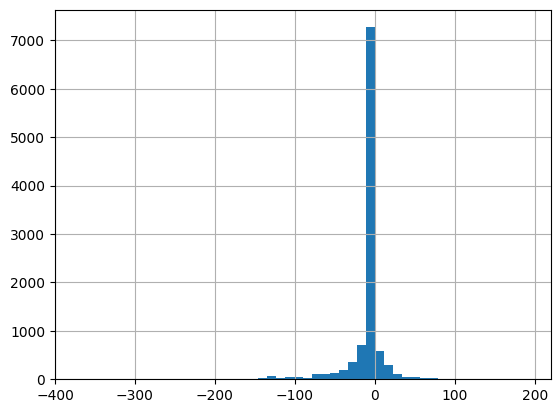

In [108]:
#Create delay features for EDA only
eda_df['delay_days'] = (eda_df['Delivered to Client Date'] - eda_df['Scheduled Delivery Date']).dt.days
eda_df['lead_time'] = (eda_df['Scheduled Delivery Date'] - eda_df['PO Sent to Vendor Date']).dt.days
eda_df['processing_time'] = (eda_df['PO Sent to Vendor Date'] - eda_df['PQ First Sent to Client Date']).dt.days
eda_df['scheduled_month'] = eda_df['Scheduled Delivery Date'].dt.month
eda_df['scheduled_quarter'] = eda_df['Scheduled Delivery Date'].dt.quarter
eda_df['scheduled_weekday'] = eda_df['Scheduled Delivery Date'].dt.weekday

eda_df['late'] = (eda_df['delay_days'] > 0).astype(int)

eda_df['delay_days'].hist(bins=50)
eda_df['late'].value_counts(normalize=True)

Late rate by Shipment Mode:


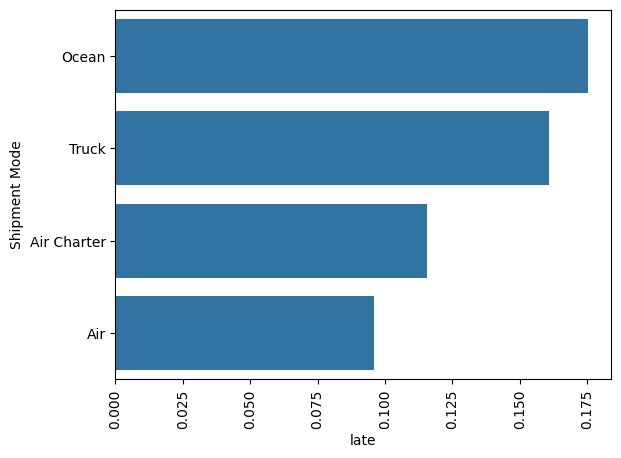

Late rate by Country:


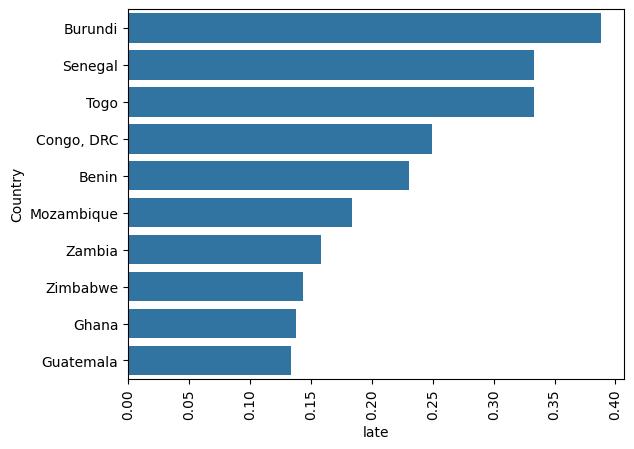

Late rate by Vendor:


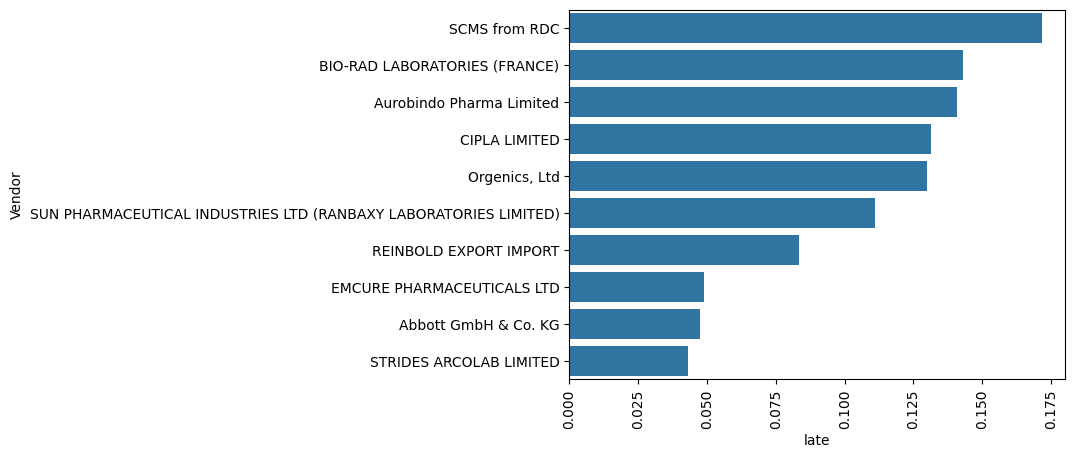

Late rate by Manufacturing Site:


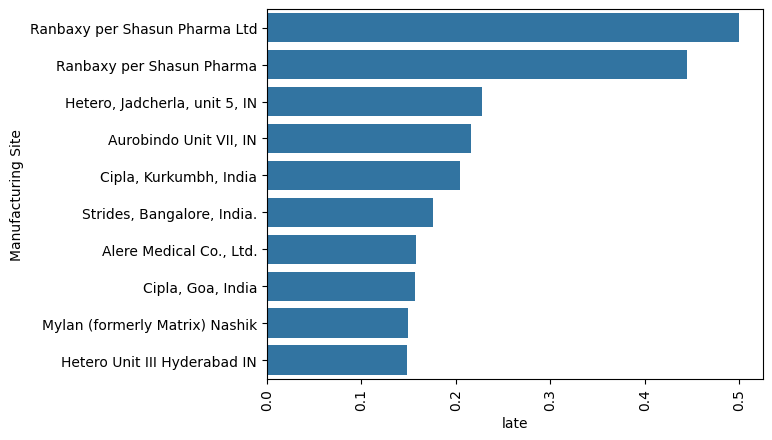

In [93]:
#check late rate by differnet categorical features - top 10 most late features
lateness_catogorical_cols = ['Shipment Mode', 'Country', 'Vendor','Manufacturing Site']
for col in lateness_catogorical_cols:
    print(f"Late rate by {col}:")
    sns.barplot(x='late', y=col, data=eda_df.groupby(col)['late'].mean().reset_index().sort_values('late', ascending=False)[:10])
    plt.xticks(rotation=90)
    plt.show()

In [95]:
#numeric summary
eda_df[num_cols].describe()


,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


<Axes: >

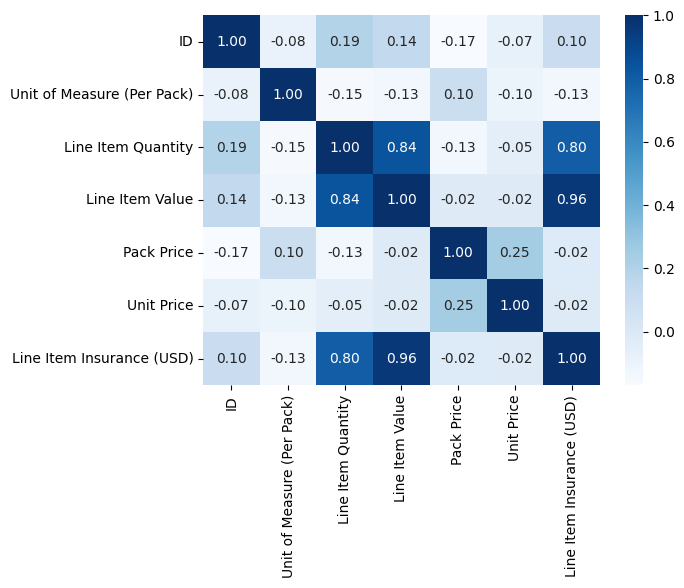

In [99]:
#heatmap
sns.heatmap(eda_df[num_cols].corr(),cmap='Blues', annot=True, fmt=".2f")

<Axes: xlabel='lead_time', ylabel='delay_days'>

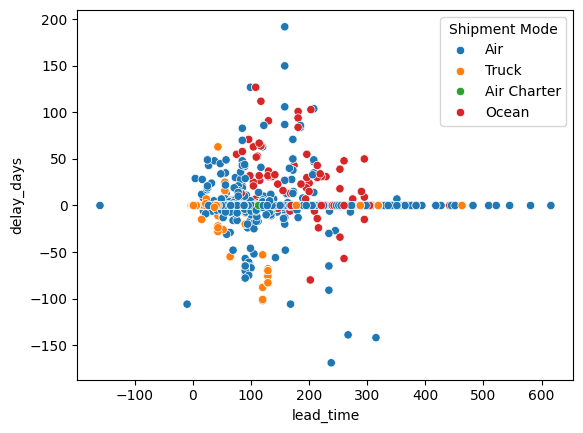

In [102]:
sns.scatterplot(x='lead_time', y='delay_days', hue='Shipment Mode', data=eda_df)


In [106]:
#value counts for categorical columns
for col in cat_cols:
    print(f"Value counts for {col}:")
    print(eda_df[col].value_counts(normalize=True).head(10))
    print("\n")

Value counts for Project Code:
Project Code
116-ZA-T30    0.074390
104-CI-T30    0.070612
151-NG-T30    0.060829
114-UG-T30    0.057730
108-VN-T30    0.050562
106-HT-T30    0.043588
111-MZ-T30    0.041747
110-ZM-T30    0.039326
109-TZ-T30    0.035742
107-RW-T30    0.032933
Name: proportion, dtype: float64


Value counts for PQ #:
PQ #
Pre-PQ Process    0.259686
FPQ-14942         0.019857
FPQ-12522         0.014917
FPQ-13973         0.010655
FPQ-4537          0.009492
FPQ-8840          0.008718
FPQ-7175          0.007555
FPQ-5303          0.007555
FPQ-6262          0.007265
FPQ-5023          0.006780
Name: proportion, dtype: float64


Value counts for PO / SO #:
PO / SO #
SCMS-199289    0.006490
SCMS-199283    0.006102
SCMS-183950    0.005327
SCMS-259075    0.003681
SCMS-215370    0.003681
SCMS-259079    0.003196
SCMS-23500     0.002518
SCMS-215410    0.002518
SCMS-162440    0.001937
SCMS-259078    0.001937
Name: proportion, dtype: float64


Value counts for ASN/DN #:
ASN/DN #
ASN-19166

<Axes: xlabel='count', ylabel='Vendor'>

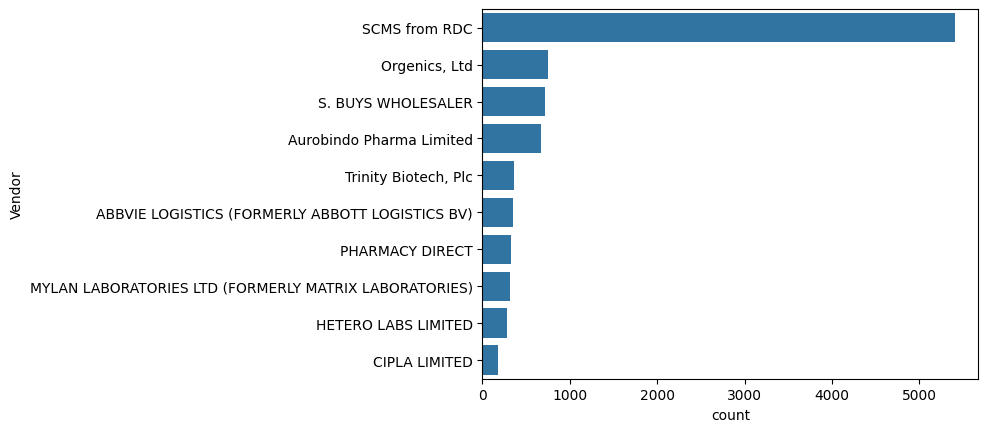

In [ ]:
#most popular vendors
sns.countplot(y='Vendor', data=eda_df, order=eda_df['Vendor'].value_counts().index[:10])


<Axes: xlabel='scheduled_month', ylabel='delay_days'>

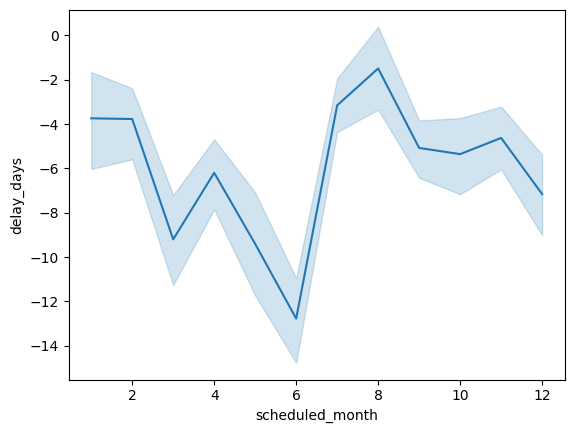

In [113]:
#delivery delay by month
sns.lineplot(x='scheduled_month', y='delay_days', data=eda_df)


In [114]:
#combined feartures
eda_df.groupby(['Shipment Mode','Country'])['late'].mean().sort_values(ascending=False)
eda_df.groupby(['Vendor','Shipment Mode'])['late'].mean().sort_values(ascending=False)


Vendor                          Shipment Mode
EMCURE PHARMACEUTICALS LTD      Ocean            0.400000
Aurobindo Pharma Limited        Ocean            0.269231
SCMS from RDC                   Truck            0.232461
CIPLA LIMITED                   Ocean            0.222222
REINBOLD EXPORT IMPORT          Truck            0.166667
                                                   ...   
HETERO LABS LIMITED             Ocean            0.000000
                                Air Charter      0.000000
GLAXOSMITHKLINE EXPORT LIMITED  Ocean            0.000000
                                Air              0.000000
ZEPHYR BIOMEDICALS              Air              0.000000
Name: late, Length: 95, dtype: float64

In [29]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["Shipment Mode"])
y = df["Shipment Mode"]
X_holdout, X_test, y_holdout, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_holdout,
    y_holdout,
    test_size=0.3,
    random_state=10
)


In [30]:
print("length of dataset:",len(df))
print("length of train set:",len(X_train))
print("length of val set:",len(X_val))
print("length of test set:",len(X_test))

length of dataset: 10324
length of train set: 5781
length of val set: 2478
length of test set: 2065
